In [1]:
%matplotlib inline

In [2]:
import os
import re
import sys
import glob

import yaml
import matplotlib
import pandas

In [3]:
sys.path.append('..')
import limeleadlib.core

In [4]:
all_results = None

for datafile in glob.glob("../content/data/benchmarks/*_processors.*"):
    from_dict = yaml.load(open(datafile, 'r'), Loader=yaml.SafeLoader)
    results_df = pandas.DataFrame.from_dict(limeleadlib.core.flatten_results(from_dict))
    results_df['isa'] = datafile.split(os.sep)[-1].split('_', 1)[0]
    if all_results is None:
        all_results = results_df
    else:
        all_results = pandas.concat((all_results, results_df))

In [5]:
SPLIT_ON_X = re.compile(r'&#215;')

def rekey_row(row):
    if '&#215' in row['clock']:
        cores, clock = map(int, SPLIT_ON_X.split(row['clock']))
    else:
        cores = 1
        clock = int(row['clock'])
    return "{} ({:d} MHz), {:1d} core{}".format(
        row['processor'],
        clock,
        cores,
        "s" if cores != 1 else "")

def humanize_secs(time_sec):
    if time_sec > 86400:
        return "{:.1f} days".format(time_sec / 86400)
    elif time_sec > 3600:
        return "{:.1f} hours".format(time_sec / 3600)
    else:
        return "{:d} seconds".format(time_sec)

def reduce_secs(time_sec):
    time_sec = int(time_sec)
    if time_sec > 3600:
        return "{:d}:{:02d}:{:02d}".format(time_sec // 3600, time_sec % 3600 // 60, time_sec % 60)
    else:
        return "{:d}:{:02d}".format(time_sec // 60, time_sec % 60)

In [6]:
isa_colormap = {k: "C{:d}".format(v) for v, k in enumerate(all_results['isa'].unique())}
print(isa_colormap)

isa_namemap = {
    "parisc": "PA-RISC",
}
print(isa_namemap)

{'x86': 'C0', 'parisc': 'C1', 'sparc': 'C2', 'power': 'C3', 'mips': 'C4', 'arm': 'C5', 'ia64': 'C6'}
{'parisc': 'PA-RISC'}


In [7]:
all_results['index'] = all_results.apply(rekey_row, axis=1)
all_results = all_results.set_index('index')

In [8]:
def plot_walltime(plot_df, key='wall_secs', ax=None):
    sorted_df = plot_df[plot_df[key].notna()].sort_values(by=key, ascending=True)
    colors = sorted_df.apply(lambda x: isa_colormap.get(x['isa'], 'black'), axis=1)

    if ax is None:
        _, ax = matplotlib.pyplot.subplots(figsize=(8, sorted_df.shape[0] / 1.75))
    ax.barh(
        y=range(sorted_df.shape[0]),
        width=sorted_df[key],
        height=0.6,
        edgecolor='black',
        color=colors,
        tick_label=sorted_df.index.values)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xscale('log', base=10)
    ax.set_yticklabels(ax.get_yticklabels())
    ax.set_ylim(-0.5, sorted_df.shape[0] - 0.5)

    legend_elements = [matplotlib.patches.Patch(facecolor=x, label=isa_namemap.get(y, y.upper())) for y, x in isa_colormap.items()]
    ax.legend(handles=legend_elements)
    ax.set_xticks([1, 60, 300, 600, 1800, 3600, 4*3600, 12*3600])
    ax.set_xticklabels(["1 second", "1 minute", "5 minutes", "10 minutes", "30 minutes", "1 hour", "4 hours", "12 hours"], ha='center', rotation=90)
    ax.tick_params(bottom=True, top=True, left=True, labelbottom=True, labeltop=True)

    for idx, walltime in enumerate(sorted_df[key]):
        ax.annotate(reduce_secs(walltime),
                    (walltime, idx),
                    textcoords="offset points",
                    xytext=(10, 0),
                    ha='left',
                    va='center',
                    fontsize="small")
    return ax

<AxesSubplot:>

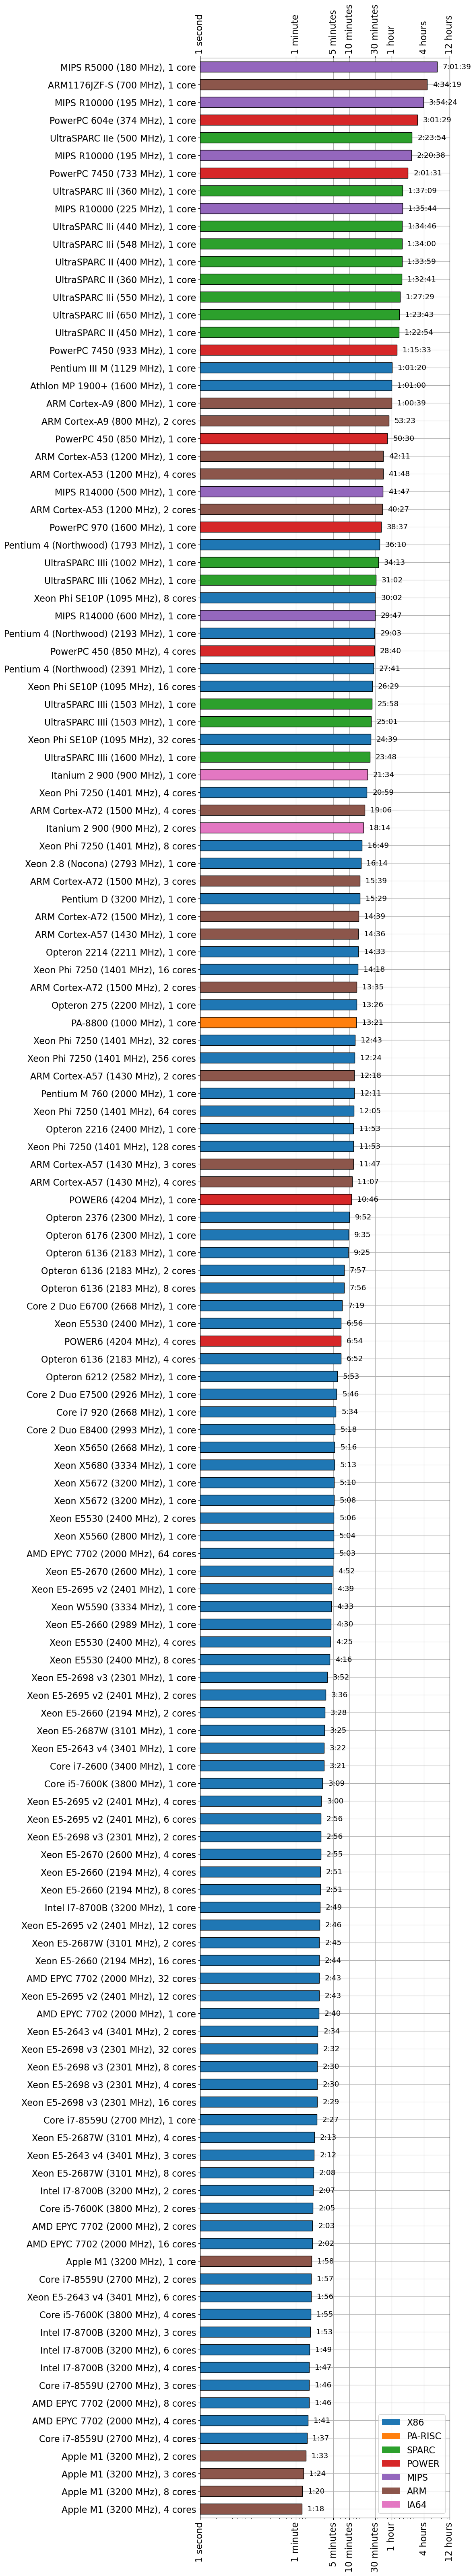

In [9]:
plot_walltime(all_results, key='wall_secs')

<AxesSubplot:>

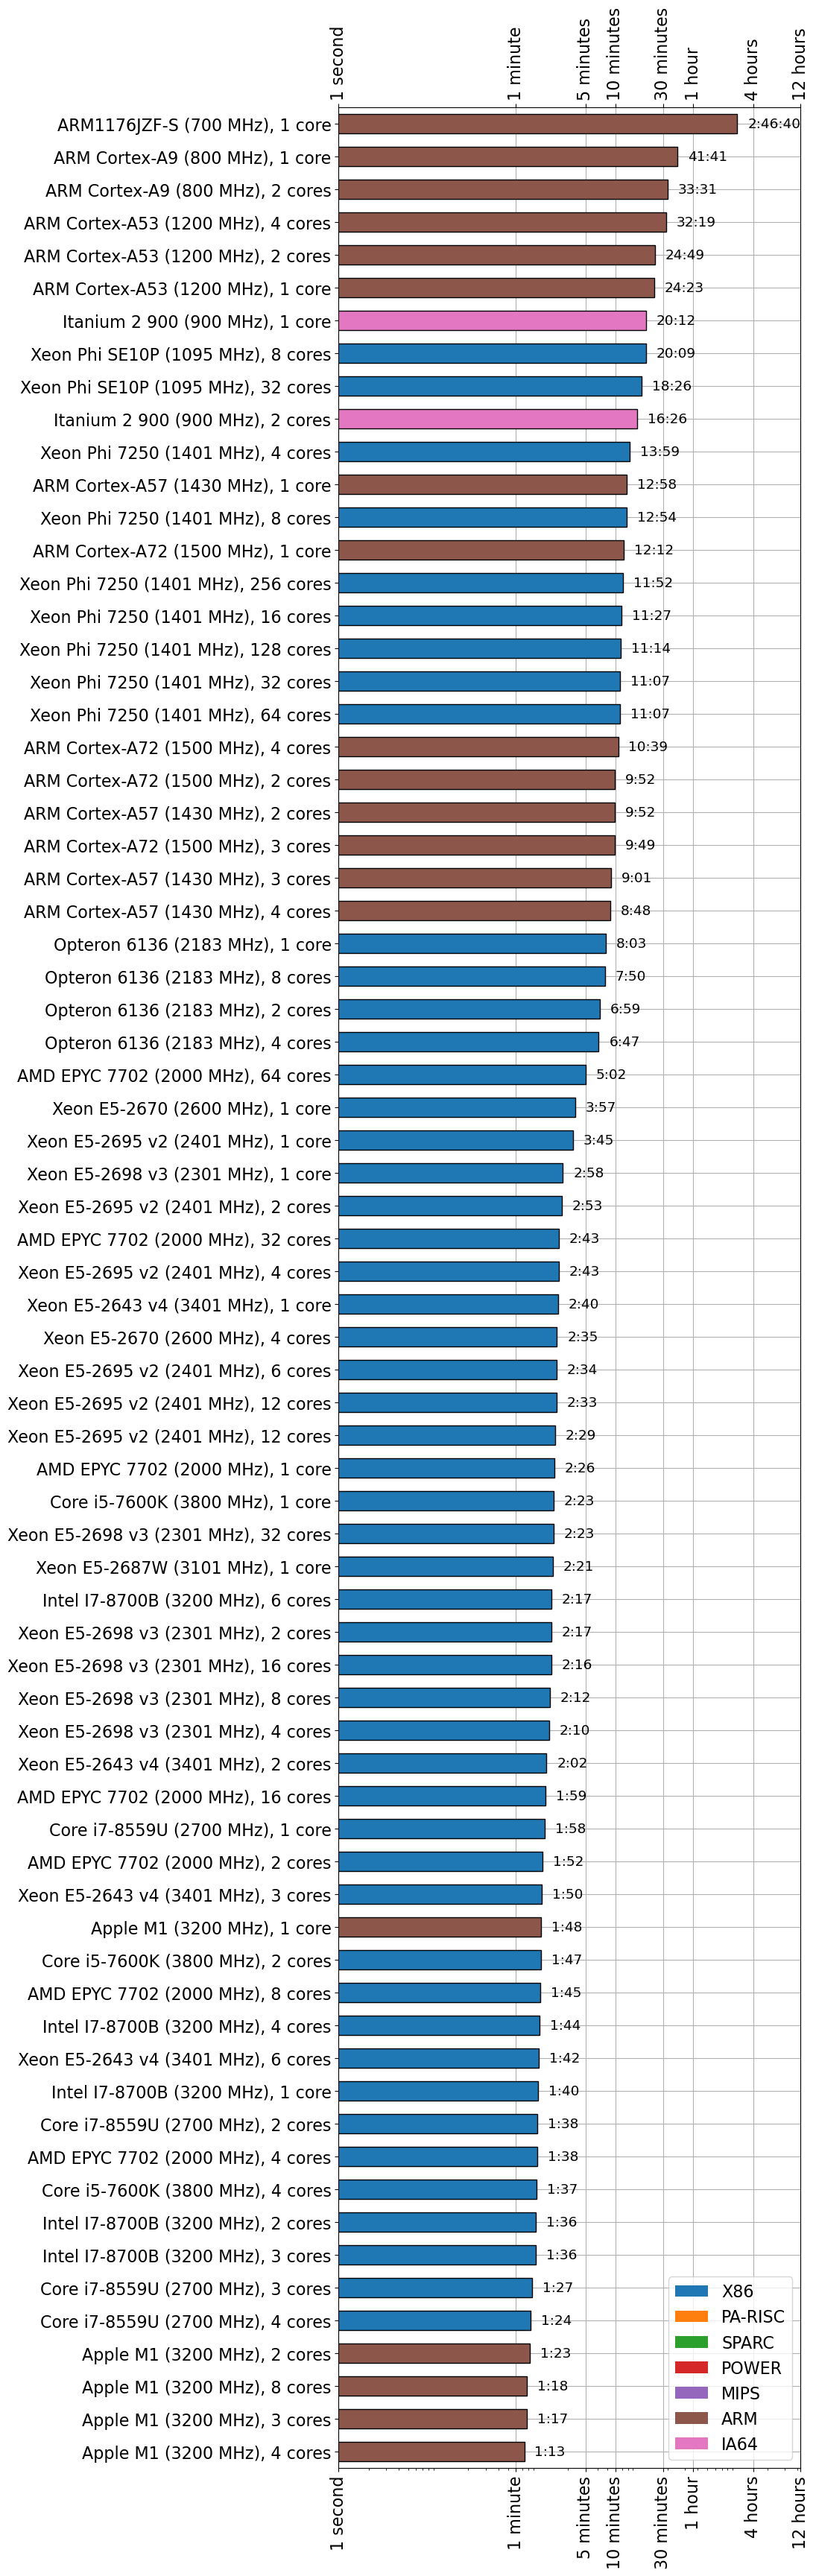

In [10]:
plot_walltime(all_results, key='memreorder_secs')